# Store Item Demand Forecasting Introduction (Time Series Analysis) 🕰️

Onur Can Memis

2040827

> In this notebook, we tackle the Demand Forecasting competition hosted on Kaggle. The challenge centers on predicting daily sales for a chain of 50 unique items across 10 different stores over the course of 5 years.

> Accurate demand forecasting is a cornerstone of retail operations — helping minimize stockouts, reduce inventory costs, and optimize replenishment cycles. Our goal is to build robust machine learning and statistical models that can effectively predict the number of items sold for a given date, item, and store.

[Kaggle Link](https://www.kaggle.com/competitions/demand-forecasting-kernels-only)

# Setup

In [2]:
%pip -q install catboost
%pip -q install pytorch-forecasting
%pip -q install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.7/197.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import pandas as pd
import time
import torch
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import shap
import numpy as np
from keras import optimizers
import tensorflow as tf
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import make_scorer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input,GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
pd.set_option('display.max_columns', None)

# Understanding the Data

## Columns

| *column_name* | *description*                                                                 |
|-------------|--------------------------------------------------------------------------|
| **date**        | Date of the sale data. There are no holiday effects or store closures.      |
| **store**       | Unique Identifier for store                                                                   |
| **item**        | Unique Identifier for item                                                                     |
| **sales**       | Number of items sold at a particular store on a particular date.            |

## EDA

In [4]:
df= pd.read_csv("dataset/train.csv",parse_dates=["date"])
df.head(3)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14


In [5]:
print("Number of unique stores in train dataset:", df.store.nunique())
print("Number of unique items in train dataset:", df.item.nunique())
print("Number of unique item-store combinations in train dataset:", df.groupby(['store', 'item']).size().shape[0])

Number of unique stores in train dataset: 10
Number of unique items in train dataset: 50
Number of unique item-store combinations in train dataset: 500


In [9]:
print(f"Training:Number of days between first and last date: {(df.date.max()-df.date.min()).days}")

Training:Number of days between first and last date: 1825


In [10]:
print(df.shape)
print("5 years of data for each of 500 item-store pair:" ,1826*500)

(913000, 4)
5 years of data for each of 500 item-store pair: 913000


In [11]:
df.groupby(['store', 'item']).size()

store  item
1      1       1826
       2       1826
       3       1826
       4       1826
       5       1826
               ... 
10     46      1826
       47      1826
       48      1826
       49      1826
       50      1826
Length: 500, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [ ]:
df.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
date,913000,2015-07-02 11:59:59.999999744,2013-01-01 00:00:00,2014-04-02 00:00:00,2015-07-02 12:00:00,2016-10-01 00:00:00,2017-12-31 00:00:00,NaN
store,913000.0,5.5,1.0,3.0,5.5,8.0,10.0,2.872283
item,913000.0,25.5,1.0,13.0,25.5,38.0,50.0,14.430878
sales,913000.0,52.250287,0.0,30.0,47.0,70.0,231.0,28.801144


In [12]:
monthly_df = (
    df.set_index('date') # resample works with index that's why we did that
      .groupby('store')['sales']
      .resample('ME') # here we resample to month
      .mean()
      .reset_index()
)
monthly_df.head()


store_ids = df['store'].unique()

fig = make_subplots(rows=2, cols=5, subplot_titles=[f"Store {s}" for s in store_ids])

# Plot each store's line
for i, store in enumerate(store_ids):
    store_data = monthly_df[monthly_df['store'] == store]
    row = i // 5 + 1
    col = i % 5 + 1
    fig.add_trace(
        go.Scatter(
            x=store_data['date'],
            y=store_data['sales'],
            mode='lines',
            name=f"Store {store}",
            hovertemplate='Date: %{x|%Y-%m-%d}<br>Sales: %{y}<extra></extra>'
        ),
        row=row, col=col
    )

fig.update_layout(
    height=600,
    width=1200,
    title_text="Sales Over Time for 10 Stores",
    showlegend=False
)

fig.show()

In [13]:
item_df = (
    df.set_index('date') # resample works with index that's why we did that
      .groupby('item')['sales']
      .resample('ME') # here we resample to month
      .mean()
      .reset_index()
)
#----------------------------------------------------------------------------
item_ids = df['item'].unique()

fig = make_subplots(rows=len(item_ids) // 5 + 1, cols=5, subplot_titles=[f"Item{s}" for s in item_ids])


for i, item in enumerate(item_ids):
    store_data = item_df[item_df['item'] == item]
    row = i // 5 + 1
    col = i % 5 + 1
    fig.add_trace(
        go.Scatter(
            x=store_data['date'],
            y=store_data['sales'],
            mode='lines',
            name=f"Item {item}",
            hovertemplate='Date: %{x|%Y-%m-%d}<br>Sales: %{y}<extra></extra>'
        ),
        row=row, col=col
    )


fig.update_layout(
    height=1000,
    width=1200,
    title_text="Sales Over Time for 50 Items",
    showlegend=False
)

fig.show()

### Key Takeaways

* We have 10 unique stores

* We have 50 different items which are sold in every store. So there is a pair  for every item-store combination

* Data spans 1825  days which is exactly 5 years. This is the case for each of these 500 item-store pairs.

* We have no missing values. **So there is 5 years data day by day for each item-store combination**

* Regardless of store and item, sales are increasing each year on average. Stating an obvious increasing trend.

* Each year sales peak around June and July

* Dataset exhibits strong seasonality for each item-store pair.


* Especially during winter, sales take a hit and hit the bottom of the year

## Feature Engineering

Since differrent algorithms require different dataset due to their assumptions and inner workings. Therefore, we'll use 4 different dataset with specifications below.

>> Creating tailored dataset for some group of algorithms made this notebook very challenging. One has to know what kind of data to feed for a certain algorithm.

>> Some dataset are created later in the code and not in this section to help user navigate better finding which dataset being used for which specific algorithm.

> ***Categorical_FeatEng_Dataset:*** Item & Store column as categorical. On top of that nearly 30 variables designed to represent time. Includes NaN values.

> ***One_Hot_FeatEng_Dataset***: Item&Store split into dummy variables. On top of that nearly 30 variables designed to represent time. Do not include rows with NaN values. (This removes almost a year's worth of data.)

> ***LSTM_Dataset***: Item,Store,and Sales columns are included but this time we create arrays with size 30 to represent sequentiality for LSTM. Time Sequences of X_LSTM containing 3 values (Item,Store,Sales) and Y_LSTM only Sales.

> ***SMA_Dataset***: Uses the base dataframe but adds moving average of last 3 years of the same day. Then uses this value as prediction. There is no training but just computation.

> ***DNN_Embedding_Dataset***: Basically uses embeddings for item and store columns on top of sales. Model learns embeddings during training.

In [14]:
def generate_time_features(df, lag_list=None, roll_list=None, fourier_order=3, period=365):
    df = df.copy()

    # === Time-Based Features ===
    df["day"] = df["date"].dt.day
    df["week"] = df["date"].dt.isocalendar().week.astype(int)
    df["dayofyear"] = df["date"].dt.dayofyear
    df["dayofweek"] = df["date"].dt.dayofweek
    df["month"] = df["date"].dt.month
    df["year"] = df["date"].dt.year
    df["weekend"] = df["date"].dt.dayofweek.isin([5, 6]).astype(int)
    df["quarter"] = df["date"].dt.quarter
    df["season"] = df["date"].dt.month.apply(lambda x: x % 12 // 3 + 1)
    df["start_of_month"] = df["date"].dt.is_month_start.astype(int)
    df["end_of_month"] = df["date"].dt.is_month_end.astype(int)
    df["start_of_quarter"] = df["date"].dt.is_quarter_start.astype(int)
    df["end_of_quarter"] = df["date"].dt.is_quarter_end.astype(int)

    # === Lag Features ===
    if lag_list is None:
        lag_list = [7, 14, 30, 90, 180, 364, 365]
    for lag in lag_list:
        df[f"lag_{lag}"] = df.groupby(["store", "item"])["sales"].shift(lag)

    # === Nested Lag / Rolling Mean Features ===
    if roll_list is None:
        roll_list = lag_list
    for window in roll_list:
        df[f"sales_roll_mean_{window}"] = (
            df.groupby(["store", "item"])["sales"]
              .transform(lambda x: x.shift(1).rolling(window=window).mean())
        )

    # === Fourier Features for Seasonality ===
    x = np.arange(len(df))
    for k in range(1, fourier_order + 1):
        df[f'sin_{period}_{k}'] = np.sin(2 * np.pi * k * x / period)
        df[f'cos_{period}_{k}'] = np.cos(2 * np.pi * k * x / period)

    return df

In [15]:
time_df = generate_time_features(df)

> To create lag variables we must group by dataframe by items and stores otherwise we'll let another **item&store** pair affect sales.

> shift(1) at the end of rolling is used to prevent data leakage. IMPORTANT CONCEPT!

<Axes: >

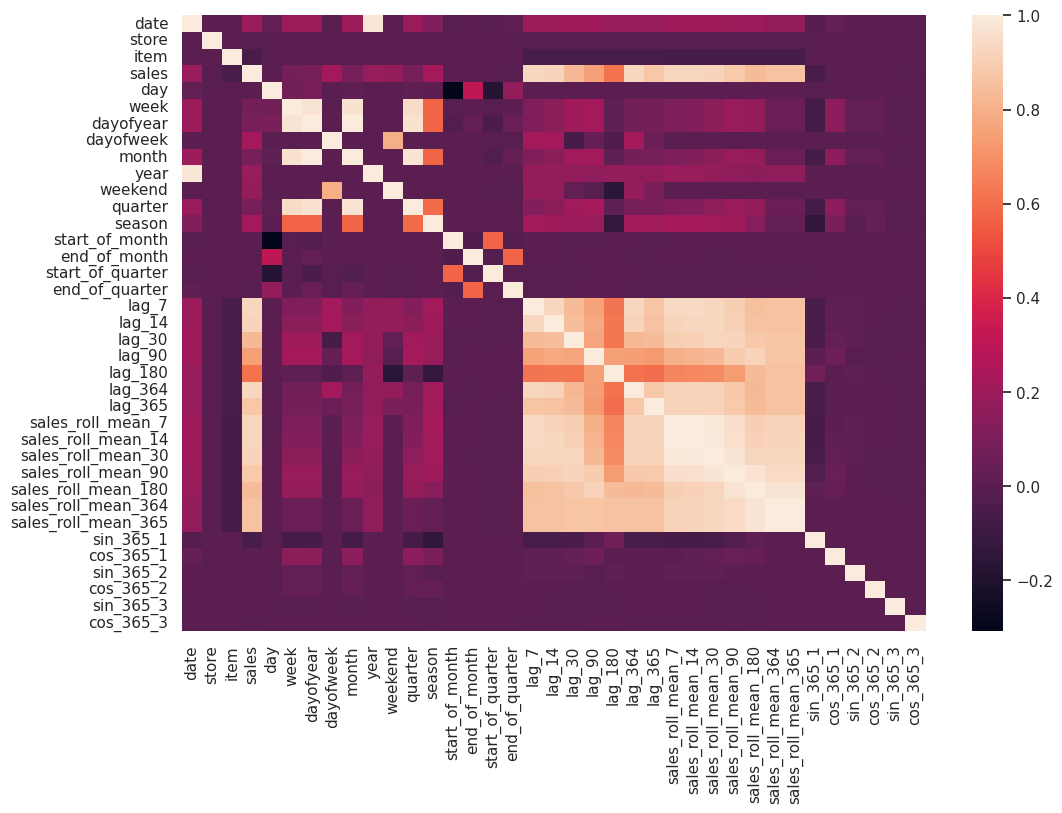

In [16]:
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
sns.heatmap(time_df.corr())

In [17]:
# We need two datasets. One with categorical item and store columns. The other with one hot encoding for MLR and MLP.
df_cat = time_df.copy()

df_cat['item'] = df_cat['item'].astype('category')
df_cat['store'] = df_cat['store'].astype('category')

# This is ready for LightGBM / XGBoost / CatBoost
#----------------------------------------------------------------------------------------
df_onehot = time_df.copy()

# Apply one-hot encoding only to ID columns
df_onehot = pd.get_dummies(df_onehot, columns=['item', 'store'], drop_first=True,dtype="int")

# Ready for scikit-learn models or MLPs

## Train-Validation-Test Split

> To ensure robust evaluation and avoid data leakage, we apply a time-aware split to the dataset. The dataset is chronologically divided into three distinct subsets:

  `Training Set:` Contains all data excluding the last 6 months. This portion is used to train the models.
  
  `Validation Set:` Consists of data from the 3 months prior to the test period. It is used for hyperparameter tuning and model selection.

  `Test Set:` The most recent 3 months of data, used exclusively for final evaluation and benchmarking

This approach simulates a real-world production environment where future values are predicted based solely on historical observations.

In [18]:
def time_split(df, date_col='date', target_col='sales', months_val=3, months_test=3):
    """
    Splits the dataframe into train, validation, and test sets based on date.

    Parameters:
    - df: pandas DataFrame (must contain a date column)
    - date_col: name of the datetime column (default 'date')
    - target_col: name of the target column (default 'sales')
    - months_val: number of months for validation set (default 3)
    - months_test: number of months for test set (default 3)

    Returns:
    - train_df, val_df, test_df (pandas DataFrames)
    """
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])

    last_date = df[date_col].max()
    test_start_date = last_date - pd.DateOffset(months=months_test)
    val_start_date = last_date - pd.DateOffset(months=months_test + months_val)

    train_df = df[df[date_col] < val_start_date]
    val_df = df[(df[date_col] >= val_start_date) & (df[date_col] < test_start_date)]
    test_df = df[df[date_col] >= test_start_date]

    return train_df, val_df, test_df

In [19]:
def split_xy(train_df, val_df, test_df,
               target_col="sales", drop_cols=["date", "sales", "year"]):
    """
    Efficiently extracts X (features) and y (targets) from train/val/test sets.

    Parameters:
    - train_df, val_df, test_df: pandas DataFrames
    - target_col: name of the target column (default: 'sales')
    - drop_cols: columns to exclude from features (default: common time/ID columns)

    Returns:
    - X_train, X_val, X_test, Y_train, Y_val, Y_test
    """
    features = [col for col in train_df.columns if col not in drop_cols]

    X_train = train_df[features]
    X_val = val_df[features]
    X_test = test_df[features]

    Y_train = train_df[target_col]
    Y_val = val_df[target_col]
    Y_test = test_df[target_col]

    return X_train, X_val, X_test, Y_train, Y_val, Y_test

In [20]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

def prepare_scaled_one_hot_dataset(train_df, val_df, test_df,
                                         exclude_from_scaling=None,
                                         target_col='sales'):
    """
    Drops all rows with NaNs from training data, scales numeric features, and
    returns MLP-ready datasets (X_train, X_val, X_test and their targets).

    Parameters:
    - train_df, val_df, test_df: input dataframes
    - exclude_from_scaling: columns to skip from standardization (e.g. one-hot/categorical)
    - target_col: name of the target column

    Returns:
    - X_train_scaled, X_val_scaled, X_test_scaled
    - Y_train, Y_val, Y_test
    """


    # Drop rows with any NaNs in training set
    train_df = train_df.dropna().copy()

    # Columns to scale (numerical only, not excluded ones)
    features_to_scale = [col for col in train_df.columns
                         if col not in ['date', 'id', target_col, 'year'] + exclude_from_scaling]

    # Create input features
    X_train = train_df[features_to_scale]
    X_val = val_df[features_to_scale]
    X_test = test_df[features_to_scale]

    # Standardize numeric columns
    scaler = StandardScaler()
    X_train_scaled_numeric = scaler.fit_transform(X_train)
    X_val_scaled_numeric = scaler.transform(X_val)
    X_test_scaled_numeric = scaler.transform(X_test)

    # Convert to DataFrames
    X_train_scaled = pd.DataFrame(X_train_scaled_numeric, columns=features_to_scale, index=train_df.index)
    X_val_scaled = pd.DataFrame(X_val_scaled_numeric, columns=features_to_scale, index=val_df.index)
    X_test_scaled = pd.DataFrame(X_test_scaled_numeric, columns=features_to_scale, index=test_df.index)

    # Target columns
    Y_train = train_df[target_col]
    Y_val = val_df[target_col]
    Y_test = test_df[target_col]

    return X_train_scaled, X_val_scaled, X_test_scaled, Y_train, Y_val, Y_test

In [21]:
# Creating split for categorical dataset
df_cat_training,df_cat_val,df_cat_test=time_split(df_cat)
X_cat_train,X_cat_val,X_cat_test,Y_train_cat,Y_val_cat,Y_test_cat=split_xy(df_cat_training,df_cat_val,df_cat_test)

# Creating split for one-hot dataset
df_onehot_training,df_onehot_val,df_onehot_test=time_split(df_onehot)
onehot_cols = [col for col in df_onehot_training.columns if 'item_' in col or 'store_' in col]
X_onehot_train, X_onehot_val, X_onehot_test, Y_train_onehot, Y_val_onehot, Y_test_onehot = prepare_scaled_one_hot_dataset(
    df_onehot_training,df_onehot_val,df_onehot_test,
    exclude_from_scaling=onehot_cols)

In [22]:
print("For each item-store pair")
print(f"Number of training days: {df_cat_training.loc[(df_cat_training.item == 1) & (df_cat_training.store == 1)].shape[0]}")
print(f"Number of validation days : {df_cat_val.loc[(df_cat_val.item == 1) & (df_cat_val.store == 1)].shape[0]}")
print(f"Number of test days: {df_cat_test.loc[(df_cat_test.item == 1) & (df_cat_test.store == 1)].shape[0]}")

For each item-store pair
Number of training days: 1641
Number of validation days : 92
Number of test days: 93


We create a dataset **without NaN** values for both deep learning and MLR(Multiple Linear Regression)

# Training

 `SMAPE: Symmetric Mean Absolute Percentage Error`

In this project, we evaluate model performance using SMAPE (Symmetric Mean Absolute Percentage Error) — a widely-used error metric in time series forecasting.

Unlike traditional metrics like MAE or MSE, SMAPE is scale-independent, making it ideal for comparing performance across products or stores with varying sales magnitudes.

SMAPE Formula:
$$
\text{SMAPE} = \frac{200}{n} \sum_{i=1}^{n} \frac{|F_i - A_i|}{|F_i| + |A_i|}
$$


> SMAPE was also recommended as the evaluation metric on the Kaggle competition page. Additionally, one of the references highlights why SMAPE is more suitable for datasets with varying magnitudes. In our case, where sales differ significantly across items and stores, it is important to use a metric that accounts for these differences. We want to avoid a scenario where one item or store dominates the overall error due to higher absolute values.

In [47]:
def smape(preds, target):
    preds = np.array(preds)
    target = np.array(target)

    # avoid division by zero
    mask = ~((preds == 0) & (target == 0))
    preds = preds[mask]
    target = target[mask]

    if len(preds) == 0:
        return np.nan  # or return 0.0 or raise a warning

    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = 200 * np.mean(num / denom)

    return float(smape_val)

Base models for each model will be used at the beginning to see their baseline performance. Those that perform better than others without any hyperparameter tuning will earn their spot for hyperparameter tuning phase.

## Machine Learning Models

For this part, tree-based machine learning algorithms were used thanks to their ability to deal with NaN values created by lag features.

Other ML algorithms don't work well or not at all with NaN values.

Base models will be used for each

In [ ]:
predictor=LGBMRegressor(random_state=384,force_row_wise=True)
start=time.time()
predictor.fit(X_cat_train,Y_train_cat)
end=time.time()
val_smape= smape(Y_val_cat, predictor.predict(X_cat_val))
train_smape= smape(Y_train_cat, predictor.predict(X_cat_train))
mse= mean_squared_error(Y_val_cat, predictor.predict(X_cat_val))
print(f"SMAPE_Train:{round(train_smape,3)}")
print(f"SMAPE_Validation:{round(val_smape,3)}")
print(f"MSE-Validation:{round(mse,3)}")
print(f"Complexity:{round(end-start,1)}")

[LightGBM] [Info] Total Bins 5026
[LightGBM] [Info] Number of data points in the train set: 820500, number of used features: 34
[LightGBM] [Info] Start training from score 51.211583
SMAPE_Train:13.064
SMAPE_Validation:11.154
MSE-Validation:74.404
Complexity:20.4


In [ ]:
# Storing results in a list
results=[]

# Predictors
cat_predictors={
    "XGBRegressor":XGBRegressor(random_state=384,tree_method='auto',enable_categorical=True),
    "CatBoostRegressor":CatBoostRegressor(random_state=384,loss_function='RMSE',cat_features=['item', 'store'],verbose=1),
    "LGBMRegressor":LGBMRegressor(random_state=384,force_row_wise=True)
}

for name,predictor in cat_predictors.items():
  start=time.time()
  predictor.fit(X_cat_train,Y_train_cat)
  end=time.time()
  val_smape= smape(Y_val_cat, predictor.predict(X_cat_val))
  train_smape= smape(Y_train_cat, predictor.predict(X_cat_train))
  mse= mean_squared_error(Y_val_cat, predictor.predict(X_cat_val))
  results.append({
      "Predictor":name,
      "SMAPE_Train":round(train_smape,3),
      "SMAPE_Validation":round(val_smape,3),
      "MSE-Validation":round(mse,3),
      "Complexity":round(end-start,1)})

Learning rate set to 0.118196
0:	learn: 25.4302011	total: 638ms	remaining: 10m 37s
1:	learn: 23.0153608	total: 1.27s	remaining: 10m 35s
2:	learn: 20.8931885	total: 2.4s	remaining: 13m 16s
3:	learn: 19.0207528	total: 3.4s	remaining: 14m 7s
4:	learn: 17.3735297	total: 4.18s	remaining: 13m 52s
5:	learn: 15.9535862	total: 4.75s	remaining: 13m 6s
6:	learn: 14.7352452	total: 5.26s	remaining: 12m 26s
7:	learn: 13.7140275	total: 5.73s	remaining: 11m 50s
8:	learn: 12.8320566	total: 6.22s	remaining: 11m 25s
9:	learn: 12.0400445	total: 6.77s	remaining: 11m 9s
10:	learn: 11.3642088	total: 7.29s	remaining: 10m 55s
11:	learn: 10.8129921	total: 7.75s	remaining: 10m 38s
12:	learn: 10.3337223	total: 8.33s	remaining: 10m 32s
13:	learn: 9.9467337	total: 8.87s	remaining: 10m 24s
14:	learn: 9.6311915	total: 9.35s	remaining: 10m 13s
15:	learn: 9.3583906	total: 9.86s	remaining: 10m 6s
16:	learn: 9.1254824	total: 10.3s	remaining: 9m 56s
17:	learn: 8.9216701	total: 10.8s	remaining: 9m 50s
18:	learn: 8.7501048	

In [ ]:
one_hot_predictors={
    "LinearRegression":LinearRegression(),
    "Ridge":Ridge(alpha=0.1),
    "Lasso":Lasso(alpha=0.1)}

for predictor,model in one_hot_predictors.items():
  start=time.time()
  model.fit(X_onehot_train,Y_train_onehot)
  end=time.time()
  val_smape= smape(Y_val_onehot, model.predict(X_onehot_val))
  train_smape= smape(Y_train_onehot, model.predict(X_onehot_train))
  mse= mean_squared_error(Y_val_onehot, model.predict(X_onehot_val))
  results.append({
      "Predictor":predictor,
      "SMAPE_Train":round(train_smape,3),
      "SMAPE_Validation":round(val_smape,3),
      "MSE-Validation":round(mse,3),
      "Complexity":round(end-start,1)})

## Deep Learning Models

For deep learning models, different architectures were used to come up with good scores.

> MLP (Multilayer Perceptron)

When it comes to MLP or Neural Networks without sequential property, we'll have to create variables that helps model understand temporality but this time NaN values are not allowed. Therefore, a smaller version of our final dataset will be used.

In [ ]:
train_emb,val_emb,test_emb=time_split(time_df.dropna())
X_train_emb,X_val_emb,X_test_emb,Y_train_emb,Y_val_emb,Y_test_emb=split_xy(train_emb,val_emb,test_emb)
X_train_store=X_train_emb["store"].to_numpy()
X_val_store=X_val_emb["store"].to_numpy()
X_test_store=X_test_emb["store"].to_numpy()
X_train_item=X_train_emb["item"].to_numpy()
X_val_item=X_val_emb["item"].to_numpy()
X_test_item=X_test_emb["item"].to_numpy()
X_train_item -= 1
X_val_item -= 1
X_train_store -= 1
X_val_store -= 1 # Embedding outputs error due to embedding_dim.
X_train_emb.drop(columns=["store","item"],inplace=True)
X_val_emb.drop(columns=["store","item"],inplace=True)
X_test_emb.drop(columns=["store","item"],inplace=True)

# Inputs
store_input = tf.keras.Input(shape=(1,), dtype='int32', name='store')
item_input = tf.keras.Input(shape=(1,), dtype='int32', name='item')
num_input = tf.keras.Input(shape=(X_train_emb.shape[1],), name='numerical_features')  # all other features

# Embeddings
store_emb = tf.keras.layers.Embedding(input_dim=10, output_dim=4)(store_input)
item_emb = tf.keras.layers.Embedding(input_dim=50, output_dim=8)(item_input)

# Flatten embeddings
store_emb = tf.keras.layers.Flatten()(store_emb)
item_emb = tf.keras.layers.Flatten()(item_emb)

# Concatenate all inputs
x = tf.keras.layers.Concatenate()([store_emb, item_emb, num_input])

# MLP architecture
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
output = tf.keras.layers.Dense(1)(x)

# Model
mlp_model_emb = tf.keras.Model(inputs=[store_input, item_input, num_input], outputs=output)

mlp_model_emb.compile(optimizer='adam', loss='mse')

# Train
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
start=time.time()
mlp_model_emb.fit(
    [X_train_store, X_train_item, X_train_emb],
    Y_train_emb,
    validation_data=([X_val_store, X_val_item, X_val_emb], Y_val_emb),
    epochs=20,
    batch_size=256,
    verbose=2,
    callbacks=[early_stop]
)
end=time.time()
val_smape= smape(Y_val_emb, mlp_model_emb.predict([X_val_store, X_val_item, X_val_emb]).flatten())
train_smape= smape(Y_train_emb, mlp_model_emb.predict([X_train_store, X_train_item, X_train_emb]).flatten())
mse= mean_squared_error(Y_val_emb, mlp_model_emb.predict([X_val_store, X_val_item, X_val_emb]).flatten())
results.append({
    "Predictor":"MLP_Embeddings",
    "SMAPE_Train":round(train_smape,3),
    "SMAPE_Validation":round(val_smape,3),
    "MSE-Validation":round(mse,3),
    "Complexity":round(end-start,1)})

<ipython-input-93-459280e60c65>:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-93-459280e60c65>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-93-459280e60c65>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Epoch 1/20
2493/2493 - 15s - 6ms/step - loss: 92.8649 - val_loss: 333.5242
Epoch 2/20
2493/2493 - 21s - 8ms/step - loss: 67.1013 - val_loss: 467.9039
Epoch 3/20
2493/2493 - 14s - 6ms/step - loss: 63.8188 - val_loss: 556.7228
Epoch 4/20
2493/2493 - 13s - 5ms/step - loss: 62.0533 - val_loss: 552.4454
Epoch 5/20
2493/2493 - 13s - 5ms/step - loss: 61.1656 - val_loss: 566.6492
Epoch 6/20
2493/2493 - 20s - 8ms/step - loss: 60.6149 - val_loss: 584.0132
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
19938/19938 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step
1438/1438 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
# A deep neural network
mlp_model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_onehot_train.shape[1],)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
# Compile the model
mlp_model_1.compile(
    optimizer='adam',
    loss='mse'
)

# A more basic neural network
mlp_model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_onehot_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

mlp_model_2.compile(
    optimizer='adam',
    loss='mse'
)
# Train the model

neural_predictors={"DNN_One_Hot":mlp_model_1,
                   "MLP_One_Hot":mlp_model_2}
for name,model in neural_predictors.items():
  start=time.time()
  model.fit(
      X_onehot_train, Y_train_onehot,
      validation_data=(X_onehot_val, Y_val_onehot),
      epochs=20,
      batch_size=256,
      verbose=1,
      callbacks=[early_stop])
  end=time.time()
  val_smape= smape(Y_val_onehot, model.predict(X_onehot_val).flatten())
  train_smape= smape(Y_train_onehot, model.predict(X_onehot_train).flatten())
  mse= mean_squared_error(Y_val_onehot, model.predict(X_onehot_val).flatten())
  results.append({
      "Predictor":name,
      "SMAPE_Train":round(train_smape,3),
      "SMAPE_Validation":round(val_smape,3),
      "MSE-Validation":round(mse,3),
      "Complexity":round(end-start,1)})

Epoch 1/20
3206/3206 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - loss: 343.6212 - val_loss: 204.1407
Epoch 2/20
3206/3206 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - loss: 106.8213 - val_loss: 234.2899
Epoch 3/20
3206/3206 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - loss: 102.3354 - val_loss: 190.0183
Epoch 4/20
3206/3206 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - loss: 100.3240 - val_loss: 195.0202
Epoch 5/20
3206/3206 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - loss: 98.1580 - val_loss: 179.6438
Epoch 6/20
3206/3206 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 96.4296 - val_loss: 192.6676
Epoch 7/20
3206/3206 ━━━━━━━━━━━━━━━━━━━━ 43s 8ms/step - loss: 94.4177 - val_loss: 206.3072
Epoch 8/20
3206/3206 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - loss: 92.6180 - val_loss: 150.3137
Epoch 9/20
3206/3206 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - loss: 90.1193 - val_loss: 217.1019
Epoch 10/20
3206/3206 ━━━━━━━━━━━━━━━━━━━━ 44s 8ms/step - loss: 87.1117 - val_loss: 164.8181
Epoch 11/20
3206/3206 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 85.1227 - v

> LSTM

In [ ]:
def create_lstm_sequences(df, sequence_length=30,stride=3):
    """
    Generates LSTM-ready sequences for a given DataFrame grouped by (store_id, item_id).

    Parameters:
    - df: pandas DataFrame
    - feature_cols: list of column names to use as input features
    - sequence_length: number of time steps in each input sequence

    Returns:
    - X: numpy array of shape (num_sequences, sequence_length, num_features)
    - y: numpy array of shape (num_sequences,)
    """
    X, y = [], []

    for (store, item), group in df.groupby(['store', 'item']):
        group = group.sort_values('date')
        values = group[["item","store","sales"]].values
        target= group["sales"].values

        for i in range(0,len(group) - sequence_length,stride):
            X.append(values[i:i+sequence_length])
            y.append(target[i + sequence_length])  # target is the next step's sales

    return np.array(X), np.array(y)

* NaN columns due to lag variables makes 182500 rows full of NaN values. This is equivalent to one year of data out of 5. It's just a small portion of dataset.
* These columns will be dropped in exchange of getting lag variables for the rest of 4 years.


> df.date.min()
>> Timestamp('2013-01-01 00:00:00')

> time_df.dropna().date.min()
>> Timestamp('2014-01-01 00:00:00')


In [ ]:
# Creating train, validation, and test sets
df_LSTM_train,df_LSTM_val,df_LSTM_test=time_split(time_df)
# Splitting them to X and Y series
df_LSTM_train.dropna(inplace=True)
num_cols = [col for col in df_LSTM_train.columns if col not in ["date","year","sales"]]
scaler = StandardScaler()
df_LSTM_train[num_cols] = scaler.fit_transform(df_LSTM_train[num_cols])
df_LSTM_val[num_cols] = scaler.transform(df_LSTM_val[num_cols])
df_LSTM_test[num_cols] = scaler.transform(df_LSTM_test[num_cols])
# Preparing sequences for LSTM
sequence_length=30
X_train, y_train = create_lstm_sequences(df_LSTM_train , sequence_length)
X_val, y_val = create_lstm_sequences(df_LSTM_val, sequence_length)
X_test, y_test = create_lstm_sequences(df_LSTM_test, sequence_length)

> GRU

In [ ]:
batch_size = 64
sequence_length = 30
num_features = X_train.shape[2]
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#LSTM model
lstm_model = Sequential([
    Input(batch_shape=(batch_size,sequence_length,num_features)),# 30 timesteps, 3 features per timestep
    LSTM(64,return_sequences=False),
    Dense(1)                        # Output one sales value
])

lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
# GRU_Model
gru_model = Sequential([
    Input(batch_shape=(batch_size, sequence_length, num_features)),
    GRU(64,return_sequences=False),
    Dense(1)])
gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

sequential_models={"LSTM":lstm_model,
                   "GRU":gru_model}

for name,model in sequential_models.items():
  start=time.time()
  model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=20,
          batch_size=64,
          shuffle=False,
          callbacks=[early_stop],
          verbose=1)
  end=time.time()
  val_smape= smape(y_val, model.predict(X_val).flatten())
  train_smape= smape(y_train, model.predict(X_train).flatten())
  mse= mean_squared_error(y_val, model.predict(X_val).flatten())
  results.append({
      "Predictor":name,
      "SMAPE_Train":round(train_smape,3),
      "SMAPE_Validation":round(val_smape,3),
      "MSE-Validation":round(mse,3),
      "Complexity":round(end-start,1)})

Epoch 1/20
3250/3250 ━━━━━━━━━━━━━━━━━━━━ 64s 19ms/step - loss: 1247.7312 - mae: 25.0597 - val_loss: 351.2716 - val_mae: 12.7109
Epoch 2/20
3250/3250 ━━━━━━━━━━━━━━━━━━━━ 82s 19ms/step - loss: 161.5401 - mae: 8.9650 - val_loss: 183.9921 - val_mae: 9.7017
Epoch 3/20
3250/3250 ━━━━━━━━━━━━━━━━━━━━ 81s 19ms/step - loss: 109.5313 - mae: 7.7697 - val_loss: 135.7295 - val_mae: 8.6008
Epoch 4/20
3250/3250 ━━━━━━━━━━━━━━━━━━━━ 84s 19ms/step - loss: 107.6546 - mae: 7.7540 - val_loss: 135.1236 - val_mae: 8.6764
Epoch 5/20
3250/3250 ━━━━━━━━━━━━━━━━━━━━ 80s 19ms/step - loss: 97.3930 - mae: 7.4375 - val_loss: 121.6130 - val_mae: 8.2935
Epoch 6/20
3250/3250 ━━━━━━━━━━━━━━━━━━━━ 61s 19ms/step - loss: 91.6948 - mae: 7.2545 - val_loss: 115.5165 - val_mae: 8.0459
Epoch 7/20
3250/3250 ━━━━━━━━━━━━━━━━━━━━ 82s 19ms/step - loss: 88.5864 - mae: 7.1364 - val_loss: 110.8764 - val_mae: 7.9754
Epoch 8/20
3250/3250 ━━━━━━━━━━━━━━━━━━━━ 62s 19ms/step - loss: 83.7143 - mae: 6.9430 - val_loss: 105.4953 - val_mae: 

## Statistical Models

In [39]:

# Seasonal Moving Average For Last 3 Years value
# Though this would be effective since data shows strong signs of seasonality. Worked out pretty well!
start=time.time()
df= pd.read_csv("dataset/train.csv",parse_dates=["date"])
df["store_item"] = df["store"].astype(str) + "_" + df["item"].astype(str)
df["year"] = df["date"].dt.year
df["month_day"] = df["date"].dt.strftime("%m-%d")



# Apply seasonal average from same day in past 3 years
df_base = df.copy()
for i in [1, 2, 3]:
    lagged = df.copy()
    lagged["year"] = lagged["year"] + i  # match future row to past year
    lagged = lagged[["store", "item", "year", "month_day", "sales"]]
    lagged = lagged.rename(columns={"sales": f"sales_lag_{i}y"})
    df_base = df_base.merge(lagged, on=["store", "item", "year", "month_day"], how="left")
# We basically add three new colums containing last 3 years matching day values
# Take the average of the 3 matching days from last 3 years !!!!!
df_base["seasonal_ma"] = df_base[[f"sales_lag_{i}y" for i in [1, 2, 3]]].mean(axis=1)
df_base.drop(columns=[f"sales_lag_{i}y" for i in [1, 2, 3]], inplace=True)

train_df,val_df,test_df=time_split(df_base)

# Drop NaNs (from missing past years)
train_df.dropna(subset=["seasonal_ma"], inplace=True)
val_df.dropna(subset=["seasonal_ma"], inplace=True)

# Evaluate
train_smape = smape(train_df["seasonal_ma"], train_df["sales"])
val_smape = smape(val_df["seasonal_ma"], val_df["sales"])
end=time.time()

sma_result = {
    'Predictor': 'Seasonal_MA_3Y',
    'SMAPE_Train': round(train_smape, 3),
    'SMAPE_Validation': round(val_smape, 3),
    'MSE-Validation': round(np.mean((val_df["seasonal_ma"] - val_df["sales"])**2), 3),
    'Complexity': round(end-start,1)
}
results.append(sma_result)

In [40]:
# Another basic model

# Simple Exponential Smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import time
df= pd.read_csv("dataset/train.csv",parse_dates=["date"])
df_exp=df.copy()
ses_preds_val, ses_preds_train = [], []
true_vals_val, true_vals_train = [], []
train_df,val_df,test_df=time_split(df_exp)
start = time.time()
for (store, item), group in tqdm(train_df.groupby(["store", "item"]), desc="Fitting SES"):
    group_sorted = group.sort_values("date")
    train_series = group_sorted["sales"].values[-1095:]  # last 2 years

    try:
        ses_model = SimpleExpSmoothing(train_series).fit()
        ses_preds_train += ses_model.fittedvalues.tolist()

        val_group = val_df[(val_df["store"] == store) & (val_df["item"] == item)]
        n_val = len(val_group)
        preds = ses_model.forecast(n_val)

        ses_preds_val += preds.tolist()
        true_vals_val += val_group.sort_values("date")["sales"].tolist()
        true_vals_train += train_series.tolist()

    except:
        continue
end = time.time()

ses_result = {
    'Predictor': 'SimpleExpSmoothing',
    'SMAPE_Train': round(smape(ses_preds_train, true_vals_train), 3),
    'SMAPE_Validation': round(smape(ses_preds_val, true_vals_val), 3),
    'MSE-Validation': round(mean_squared_error(true_vals_val, ses_preds_val), 3),
    'Complexity': round(end - start, 1)
    }
results.append(ses_result)


# Holt-Winters Exponential Smoothing
hw_preds_val, hw_preds_train = [], []
true_vals_val, true_vals_train = [], []

start = time.time()
for (store, item), group in tqdm(train_df.groupby(["store", "item"]), desc="Fitting Holt-Winters"):
    group_sorted = group.sort_values("date")
    train_series = group_sorted["sales"].values[-1095:]  # last 2 years

    try:
        hw_model = ExponentialSmoothing(train_series, trend="add", seasonal="add", seasonal_periods=30).fit()
        hw_preds_train += hw_model.fittedvalues.tolist()

        val_group = val_df[(val_df["store"] == store) & (val_df["item"] == item)]
        n_val = len(val_group)
        preds = hw_model.forecast(n_val)

        hw_preds_val += preds.tolist()
        true_vals_val += val_group.sort_values("date")["sales"].tolist()
        true_vals_train += train_series.tolist()

    except:
        continue
end = time.time()

hw_result = {
    'Predictor': 'Holt-Winters',
    'SMAPE_Train': round(smape(hw_preds_train, true_vals_train), 3),
    'SMAPE_Validation': round(smape(hw_preds_val, true_vals_val), 3),
    'MSE-Validation': round(mean_squared_error(true_vals_val, hw_preds_val), 3),
    'Complexity': round(end - start, 1)
}
results.append(hw_result)

Fitting Holt-Winters: 100%|██████████| 500/500 [02:33<00:00,  3.25it/s]


## Comparing Models

In [41]:
df_results = pd.DataFrame(results)
df_results.sort_values("SMAPE_Validation", inplace=True,ascending=True)
df_results.reset_index(drop=True, inplace=True)
df_results

,Predictor,SMAPE_Train,SMAPE_Validation,MSE-Validation,Complexity
0,CatBoostRegressor,12.706,10.877,70.185,740.4
1,XGBRegressor,12.783,11.067,73.276,26.2
2,LGBMRegressor,13.064,11.154,74.404,22.7
3,LSTM,13.502,12.193,81.934,1496.9
4,GRU,14.172,12.308,84.217,1544.7
5,DNN_One_Hot,15.565,15.120,150.314,436.0
6,MLP_One_Hot,15.193,15.784,165.136,184.5
7,SimpleExpSmoothing,17.246,16.704,200.885,6.1
8,Holt-Winters,17.318,19.838,332.341,155.1
9,Seasonal_MA_3Y,23.927,20.581,287.791,8.8


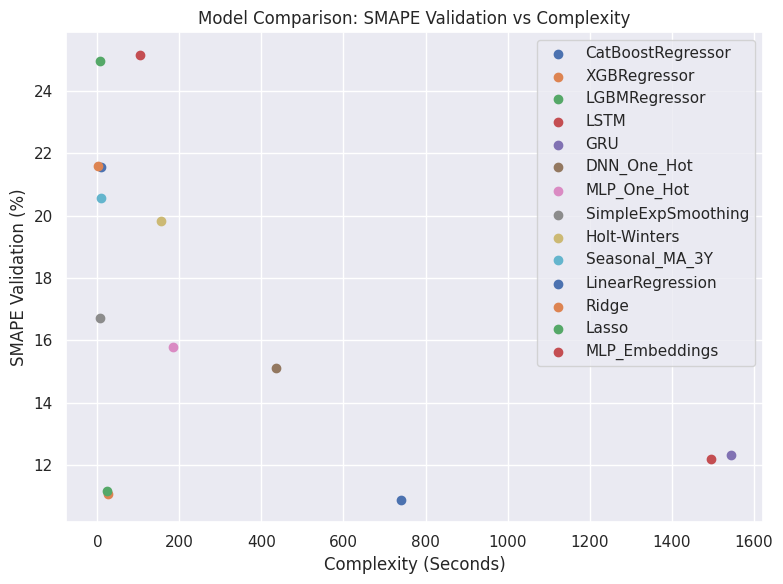

In [42]:
plt.figure(figsize=(8, 6))
for i in range(len(df_results)):
    plt.scatter(df_results.loc[i, "Complexity"],
                df_results.loc[i, "SMAPE_Validation"],
                label=df_results.loc[i, "Predictor"])
plt.xlabel("Complexity (Seconds)")
plt.ylabel("SMAPE Validation (%)")
plt.title("Model Comparison: SMAPE Validation vs Complexity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


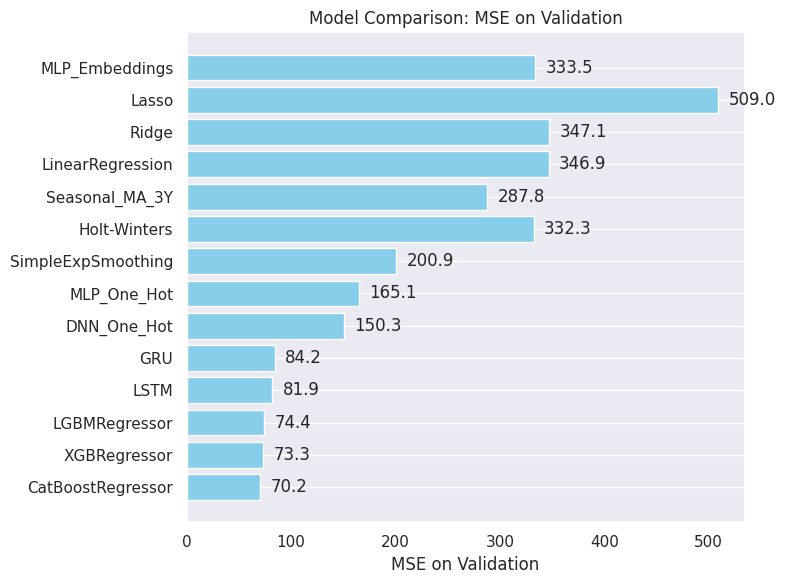

In [43]:
plt.figure(figsize=(8, 6))
bars = plt.barh(df_results["Predictor"], df_results["MSE-Validation"], color="skyblue")
for bar in bars:
    width = bar.get_width()
    plt.text(width + 10, bar.get_y() + bar.get_height()/2,
             f"{width:.1f}", va='center')
plt.xlabel("MSE on Validation")
plt.title("Model Comparison: MSE on Validation")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

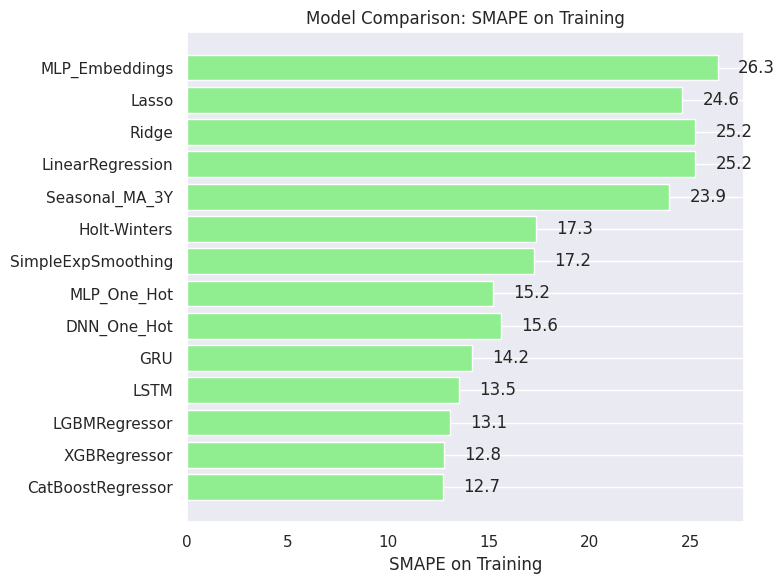

In [44]:
plt.figure(figsize=(8, 6))
bars = plt.barh(df_results["Predictor"], df_results["SMAPE_Train"], color="lightgreen")
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2,
             f"{width:.1f}", va='center')
plt.xlabel("SMAPE on Training")
plt.title("Model Comparison: SMAPE on Training")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

> To put it simply I had two baseline models: **Linear Regression** and **3 Year Seasonal Moving Average**. These models were designed to set the baseline. These models provided a good way how our best performers perform compared to somehow naive methods.

> Some Deep Learning models with sequantiality like LSTM and GRU performed way better than expected with a lot less variables ( only 3 variables item, store, and sales) than top 3 performing models. But training these sequential models were infeasible due time complexity.

> MLP with embeddings were expected to outperform other Deep Learning models but it fell short unexpectedly becoming one of the worst performers.

> Among the evaluated models, both LGBMRegressor and XGBRegressor demonstrated the best overall performance, achieving low error rates on both training and validation sets while maintaining minimal computational complexity.

> Although CatBoostRegressor delivered comparable predictive accuracy, its training time was significantly longer — nearly 50 times that of the other two models — which may limit its practicality in time-sensitive or resource-constrained environments.

> I chose to move with LGBMRegressor since it's easier to use SHAP with that model.

## Hyperparameter Tuning with Best Candidates

In [ ]:
smape_scorer = make_scorer(smape, greater_is_better=False)


lgb_model = LGBMRegressor(random_state=384,
                          force_row_wise=True,
                          verbose=1,
                          categorical_feature="auto")


param_dist = {
    'num_leaves': randint(30, 150),
    'max_depth': randint(4,8),
    'learning_rate': uniform(0.01, 0.2),
    'n_estimators': randint(100, 500),
    'min_child_samples': randint(20, 100),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
}

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist
    n_iter=25,
    scoring=smape_scorer,
    cv=2,
    verbose=2,
    random_state=384,
    n_jobs=-1,
    return_train_score=True
)

# Fit on training data
random_search.fit(X_cat_train, Y_train_cat)

# Best model
best_lgb = random_search.best_estimator_

# Evaluate
train_smape = smape(Y_train_cat, best_lgb.predict(X_cat_train))
val_smape = smape(Y_val_cat, best_lgb.predict(X_cat_val))

print("✅ Best Params:", random_search.best_params_)
print(f"✅ SMAPE on Training: {train_smape:.2f}")
print(f"✅ SMAPE on Validation: {val_smape:.2f}")

Fitting 2 folds for each of 25 candidates, totalling 50 fits


/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2118: UserWarning:

categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2140: UserWarning:

categorical_feature in param dict is overridden.



[LightGBM] [Warning] categorical_feature is set=auto, categorical_column=0,1 will be ignored. Current value: categorical_feature=auto
[LightGBM] [Info] Total Bins 5026
[LightGBM] [Info] Number of data points in the train set: 820500, number of used features: 34
[LightGBM] [Info] Start training from score 51.211583
✅ Best Params: {'colsample_bytree': np.float64(0.7570034794686191), 'learning_rate': np.float64(0.01229944754884972), 'max_depth': 8, 'min_child_samples': 40, 'n_estimators': 885, 'num_leaves': 73, 'subsample': np.float64(0.7569800139160493)}
✅ SMAPE on Training: 12.90
✅ SMAPE on Validation: 11.04


> I chose to move forward with RandomizedSearch because with crossvalidation and number of hyperparameter combination, it seemed unnecessary or overkill to be exact.

`The gains we get from extra precision from GridSearch would have been overshadowed by its inefficient complexity.`

In [34]:
# I had to rerun the RandomSearchCV to a variable for best parameters so I just copy pasted values from the output of previous run!
best_params_dict={'colsample_bytree': np.float64(0.7570034794686191), 'learning_rate': np.float64(0.01229944754884972),
                  'max_depth': 8, 'min_child_samples': 40, 'n_estimators': 885, 'num_leaves': 73, 'subsample': np.float64(0.7569800139160493)}
best_lgb=LGBMRegressor(random_state=384,force_row_wise=True,**best_params_dict)

In [32]:
df_compare = pd.DataFrame({
    "Base Model": pd.Series(LGBMRegressor(random_state=384,force_row_wise=True).get_params()),
    "Tuned Model": pd.Series(best_lgb.get_params())
})
display(df_compare[df_compare["Base Model"] != df_compare["Tuned Model"]])
# We only want to see changed hyperparameters.

,Base Model,Tuned Model
class_weight,None,None
colsample_bytree,1.0,0.757003
learning_rate,0.1,0.012299
max_depth,-1,8
min_child_samples,20,40
n_estimators,100,885
n_jobs,None,None
num_leaves,31,73
objective,None,None
subsample,1.0,0.75698


| Parameter           | Description                                                                 |
|---------------------|-----------------------------------------------------------------------------|
| `num_leaves`        | Controls the complexity of each tree. More leaves = more flexible model.    |
| `max_depth`         | Limits how deep each tree can grow. Prevents overfitting.                   |
| `learning_rate`     | Shrinks the impact of each tree. Lower values = slower but more stable.     |
| `n_estimators`      | Number of trees in the model. More trees = better fit, but slower.          |
| `min_child_samples` | Minimum data needed in a leaf. Higher value = more conservative model.      |
| `subsample`         | Fraction of rows used per tree. Helps avoid overfitting (like dropout).     |
| `colsample_bytree`  | Fraction of columns (features) used per tree. Adds randomness for robustness.|

Your tuned model found a balance between model complexity and regularization:

  * `Lower learning_rate + Higher n_estimators:` This is a classic combo. The model learns slowly and carefully, adjusting gently as it sees more trees. This often leads to better generalization.

  * `Higher num_leaves + limited max_depth:` While num_leaves increased to 73, max_depth=8 actually constrains tree complexity more than the unlimited base model. This creates more balanced tree structures that capture patterns without overfitting.

  * `Row and feature sampling (subsample, colsample_bytree):` Introduces randomness, which helps reduce variance (overfitting), especially helpful for datasets with repeated patterns like yours.

  * `Increased min_child_samples:` Prevents the model from learning from very small, noisy subsets.
  

In [49]:
start=time.time()
best_lgb.fit(
    X_cat_train, Y_train_cat,
    categorical_feature=['store', 'item'],
)
end=time.time()
train_smape = smape(Y_train_cat, best_lgb.predict(X_cat_train))
val_smape = smape(Y_val_cat, best_lgb.predict(X_cat_val))
results.append({
    "Predictor":"LGBMRegressor_with_Hyperparameter",
    "SMAPE_Train":round(train_smape,3),
    "SMAPE_Validation":round(val_smape,3),
    "MSE-Validation":round(mean_squared_error(Y_val_cat, best_lgb.predict(X_cat_val)),3),
    "Complexity":round(end-start,1)})

[LightGBM] [Info] Total Bins 5026
[LightGBM] [Info] Number of data points in the train set: 820500, number of used features: 34
[LightGBM] [Info] Start training from score 51.211583


In [50]:
df_selected = pd.DataFrame([res for res in results if res['Predictor'] in ["LGBMRegressor_with_Hyperparameter","LGBMRegressor"]])
print("----------Comparison between base and fine-tuned LGBMRegressor----------")
display(df_selected)

----------Comparison between base and fine-tuned LGBMRegressor----------


,Predictor,SMAPE_Train,SMAPE_Validation,MSE-Validation,Complexity
0,LGBMRegressor,13.064,11.154,74.404,22.7
1,LGBMRegressor_with_Hyperparameter,12.897,11.042,72.362,153.1


> Eventhough, the performance slightly improved this costed model much more time.

# SHAP

In [51]:
final_lgb_model

LGBMRegressor(colsample_bytree=np.float64(0.7570034794686191),
              force_row_wise=True,
              learning_rate=np.float64(0.01229944754884972), max_depth=8,
              min_child_samples=40, n_estimators=885, num_leaves=73,
              random_state=384, subsample=np.float64(0.7569800139160493))

In [ ]:
explainer = shap.Explainer(best_lgb)
shap_values_train = explainer(X_cat_train)
shap_values_valid = explainer(X_cat_val)

len(shap_values_train), len(shap_values_valid)

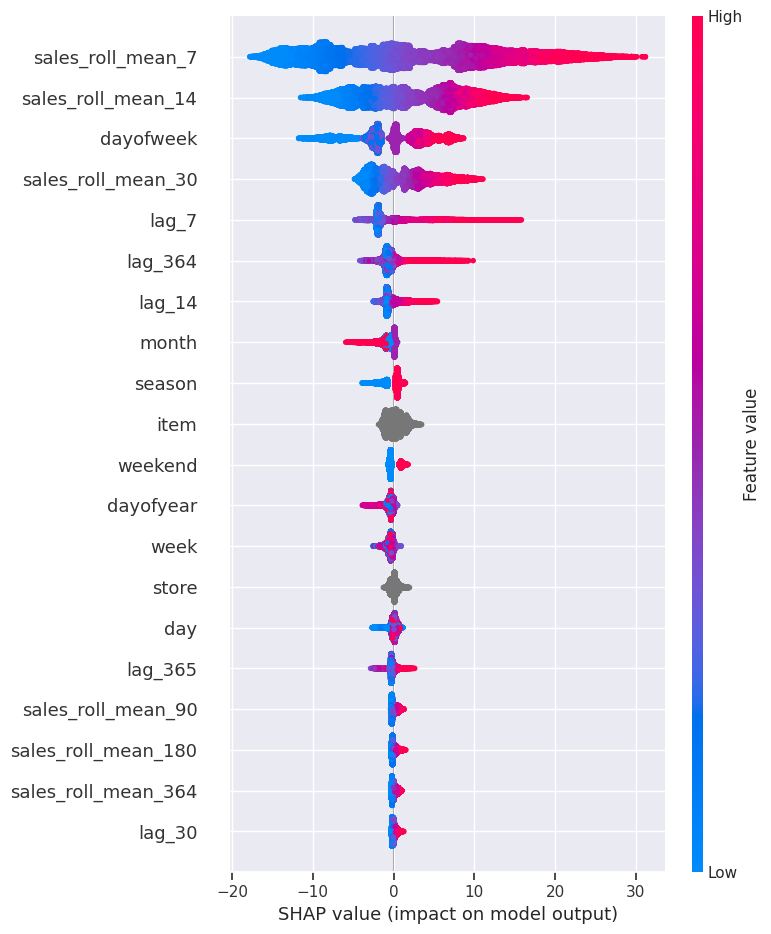

In [52]:
explainer = shap.Explainer(best_lgb)
shap_values_test= explainer(X_cat_test)

shap.summary_plot(shap_values_test,X_cat_test,feature_names=X_cat_test.columns)

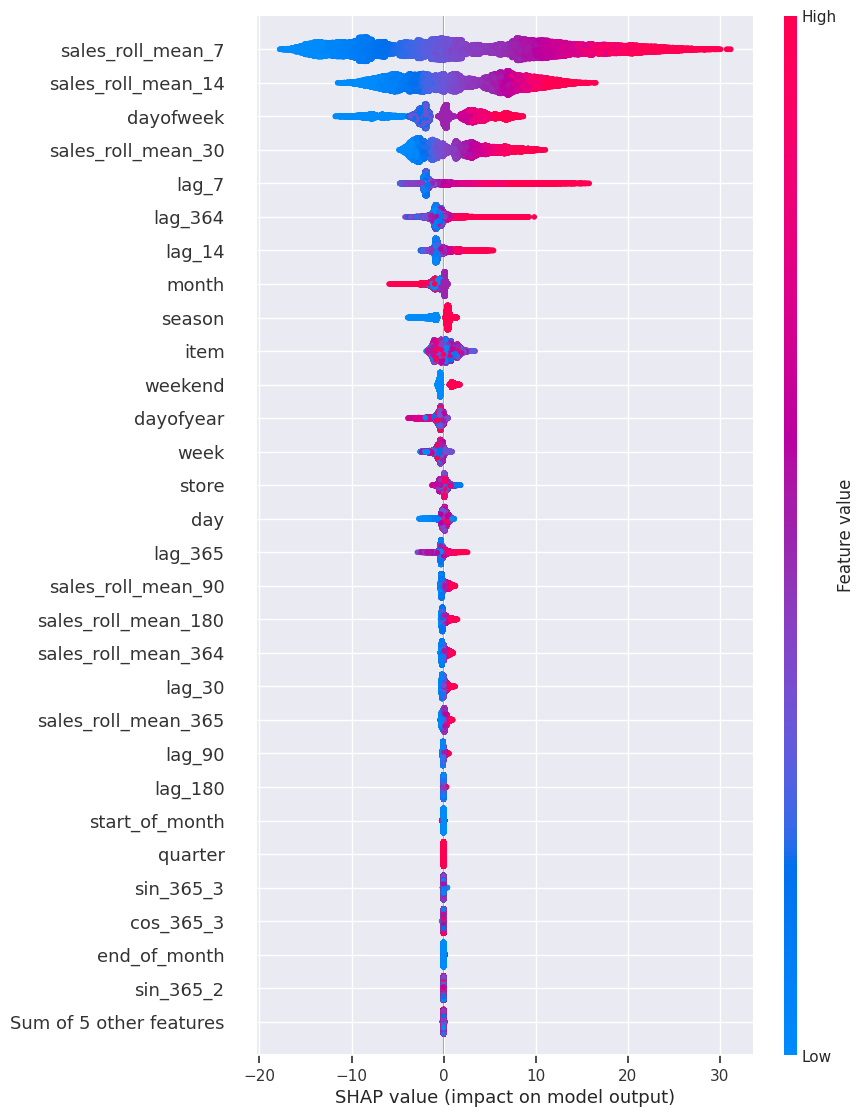

In [54]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values_test, max_display=30)

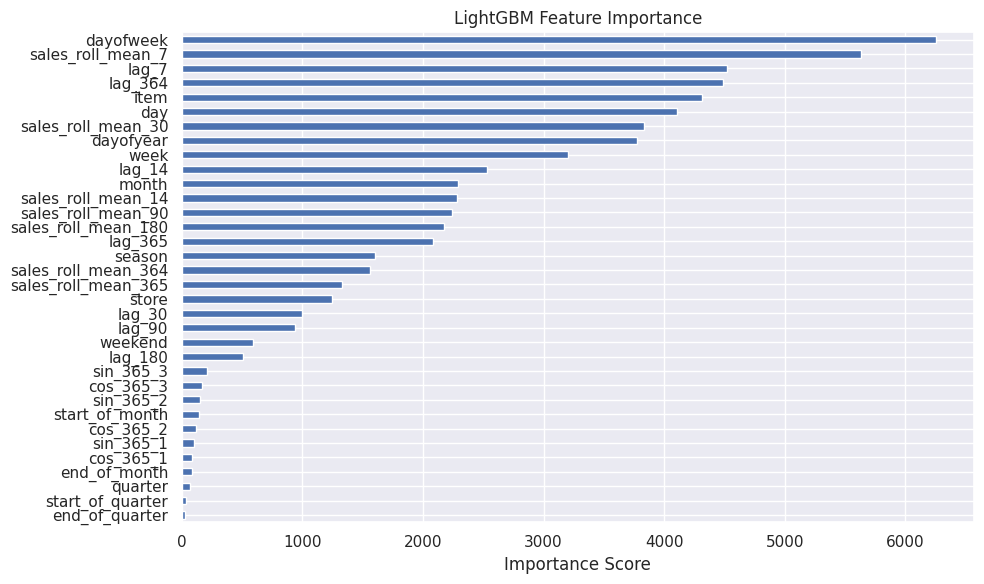

In [57]:
# Get feature importances from the best LGBM model
feature_importance = pd.Series(best_lgb.feature_importances_, index=X_cat_test.columns)

# Sort importances in ascending order
sorted_importance = feature_importance.sort_values(ascending=True)

# Plot horizontal bar chart
plt.figure(figsize=(10, 6))
sorted_importance.plot(kind='barh', title="LightGBM Feature Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# 📊 Observations & Interpretation

To understand how our tuned LightGBM model makes predictions, we examined two complementary analysis methods: **LightGBM's built-in feature importance** and **SHAP (SHapley Additive exPlanations) values**. While feature importance tells us how many times a feature was selected across trees, SHAP tells us how much a variable affects the outcome. Feature importance represents global impact, while SHAP represents local impact!

## 1. Global Feature Importance Analysis (LightGBM Bar Chart)

The horizontal bar chart shows how frequently each feature was selected for splitting decisions across all trees in our model. Features that appear more often are considered more important for making accurate predictions.

| **Rank** | **Feature** | **What This Tells Us** |
|----------|-------------|-------------------------|
| 1️⃣ | **dayofweek** | Our model heavily relies on weekly patterns—sales clearly differ between weekdays and weekends |
| 2️⃣ | **sales_roll_mean_7** | Recent 7-day average sales is critical—the model uses short-term trends to predict future demand |
| 3️⃣ | **lag_7** | Sales from exactly one week ago strongly influence current predictions—reinforces weekly seasonality |
| 4️⃣ | **lag_364** | Sales from the same day last year matter significantly—captures annual patterns like holidays |
| 5️⃣ | **item** | Different products have different demand behaviors—the model adapts its predictions per item |
| 6️⃣ | **day** | Day of the month shows importance—suggests monthly sales cycles or calendar effects |
| 7️⃣ | **sales_roll_mean_30** | Longer-term 30-day trends help smooth out daily noise and capture broader patterns |
| 8️⃣ | **dayofyear** | Position within the year (1-365) helps identify seasonal events and holidays |
| 9️⃣ | **week** | Week number reinforces multiple overlapping seasonal cycles |
| 🔟 | **lag_14** | Two-week lag provides additional temporal context, though less powerful than lag_7 |

## 2. SHAP Impact Analysis (Beeswarm Plot)

While feature importance shows us *which* features matter most, SHAP analysis reveals *how* different feature values actually influence predictions. In the beeswarm plot, each dot represents one prediction, with colors showing feature values (blue = low, red/pink = high) and horizontal position showing impact direction.

### Key Patterns We Observed:

* **Rolling averages (sales_roll_mean_7, _14)**: When recent sales are high , predictions increase significantly. When recent sales are low, predictions decrease. This makes intuitive sense—recent performance indicates near-future trends.

* **Weekly patterns (dayofweek, lag_7)**: The model clearly learned different behaviors for different days of the week, with some days consistently boosting predictions while others suppress them.

* **Annual seasonality (lag_364, dayofyear)**: The model successfully captures year-over-year patterns, using historical data from the same time periods to inform current predictions.

* **Item-specific behavior**: Different items show different baseline prediction adjustments, confirming that our model personalizes forecasts per product.

* **Calendar effects (weekend, season, month)**: These binary and categorical features create distinct prediction shifts, showing the model learned to recognize different time periods.

## Key Takeaways

* **Time-based features are crucial**: Our top features are almost entirely temporal (lags, rolling averages, date components). This validates our feature engineering strategy for time series forecasting.

* **Multiple seasonality levels**: The model simultaneously captures daily, weekly, monthly, and yearly patterns—showing why comprehensive feature engineering matters.

* **SHAP adds explanatory power**: While importance rankings tell us *what* features matter, SHAP explains *why* and *how* they influence specific predictions, making our model more interpretable.

* **Feature interactions exist**: SHAP reveals that the same feature can have different impacts depending on context—for example, weekend effects vary by item type.

# Test Results

In [58]:
test_preds = best_lgb.predict(X_cat_test)
test_smape = smape(Y_test_cat, test_preds)
test_mse = mean_squared_error(Y_test_cat, test_preds)
print(f"✅ Test SMAPE: {test_smape:.2f}")
print(f"✅ Test MSE: {test_mse:.2f}")

✅ Test SMAPE: 12.48
✅ Test MSE: 59.06


# Conclusion

> This project demonstrated that there are many ways to approach multi-time series analysis problems. In our case, we had 500 different time sequences. We explored traditional machine learning methods, deep learning models, sequential deep learning architectures, and — last but not least — basic statistical models. Each modeling group required a different dataset structure, which posed a challenge: preparing distinct datasets for different algorithms. However, using a variety of algorithms brought diversity and enhanced the overall predictive power of our solution.

> Among all models, three boosting algorithms outperformed the rest — not just by a small margin in terms of error, but by a significant margin in terms of complexity. For example, the LSTM architecture delivered similar error levels to the boosting algorithms, but its complexity — even though it used only three variables — was much higher. While all three boosting models performed similarly, we first eliminated CatBoostRegressor due to its complexity. Then, we removed XGBRegressor, choosing LGBMRegressor as the final model due to its efficiency and familiarity.

> We then applied RandomizedSearchCV to improve performance, which led to an SMAPE improvement from 11.154 to 11.042. This improvement came from reducing the learning rate, increasing the number of estimators and leaves, and adding regularization through parameters like max_depth.

> Finally, we used tools like SHAP to interpret the model’s predictions and understand which features contributed most. dayofweek, and the rolling averages over 7, 14, and 30 days emerged as the strongest predictors. We can confidently say that our feature engineering was highly effective, as the most influential variables — if not all — were created during that process.

## References
https://medium.com/data-science-at-microsoft/introduction-to-feature-engineering-for-time-series-forecasting-620aa55fcab0

https://stackoverflow.com/questions/44124436/python-datetime-to-season

https://www.geeksforgeeks.org/how-to-calculate-smape-in-python/

https://medium.com/data-science/modeling-variable-seasonal-features-with-the-fourier-transform-18c792102047

https://philipperemy.github.io/keras-stateful-lstm/

https://pytorch-forecasting.readthedocs.io/en/stable/api/pytorch_forecasting.models.baseline.Baseline.html

https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/deepar.html

ChatGPT was used for support during phrasing or grammatical correction.